In [6]:
!pip install tqdm
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.datasets import mnist
from tqdm import tqdm
from skimage.io import imshow
import tensorflow.keras.utils as np_utils
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix,f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from tensorflow.keras.utils import img_to_array , to_categorical
from tensorflow.keras import layers, models
from imutils import paths
import random
import os




In [2]:
path_dataset = "./dados"



In [12]:


#Carrega a lista de labels
label_dict = {}

for i, d in enumerate(sorted(os.listdir(path_dataset))):
    label_dict[d] = i
    print(label_dict[d])





#Calcula a quantidade de classes
num_classes = len(label_dict)
print(num_classes) # deve dar 5

# neutralidade(6),
# felicidade(3), 
# irritação(0), 
# surpresa(5)
# tristeza(4)


0
1
2
3
4
5


In [9]:
# grab the image paths and randomly shuffle them
imagePaths = sorted(list(paths.list_images(path_dataset)))
print(imagePaths[-5:])
random.seed(42)
random.shuffle(imagePaths)
#print(imagePaths)

['./dados\\tristeza\\image0030485.jpg', './dados\\tristeza\\image0030488.jpg', './dados\\tristeza\\image0030489.jpg', './dados\\tristeza\\image0030490.jpg', './dados\\tristeza\\image0030491.jpg']


In [18]:
labels = []
data = []

print("[INFO] loading images...")
# loop over the input images
none_image = 0
for imagePath in tqdm(imagePaths):
    # load the image, pre-process it, and store it in the data list
    # print(f"image_path=\n{imagePath}")
    image = cv2.imread(imagePath)
    if image is not None:
        # print(f"image=\n{image}")
        image = cv2.resize(image, (64, 64))
        #Converts Image instance to a Numpy array
        image = img_to_array(image)
        data.append(image)

        # extract the class label from the image path and update the
        # labels list


        label = label_dict[imagePath.split(os.path.sep)[-2]]
        # print(label)
        labels.append(label)
    else:
        none_image += 1
print(none_image)

[INFO] loading images...


100%|██████████| 25000/25000 [01:32<00:00, 271.09it/s]

5000


In [19]:
# scale the raw pixel intensities to the range [0, 1]
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)

# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
(train_images, test_images, train_l, test_l) = train_test_split( data, labels, test_size=0.50, random_state=42)
print(train_l)
print(test_l)
print(num_classes)
# convert the labels from integers to vectors
train_labels = np_utils.to_categorical(train_l, num_classes=num_classes)
test_labels = np_utils.to_categorical(test_l, num_classes=num_classes)

[0 3 0 ... 2 2 3]
[3 0 4 ... 0 2 3]
5


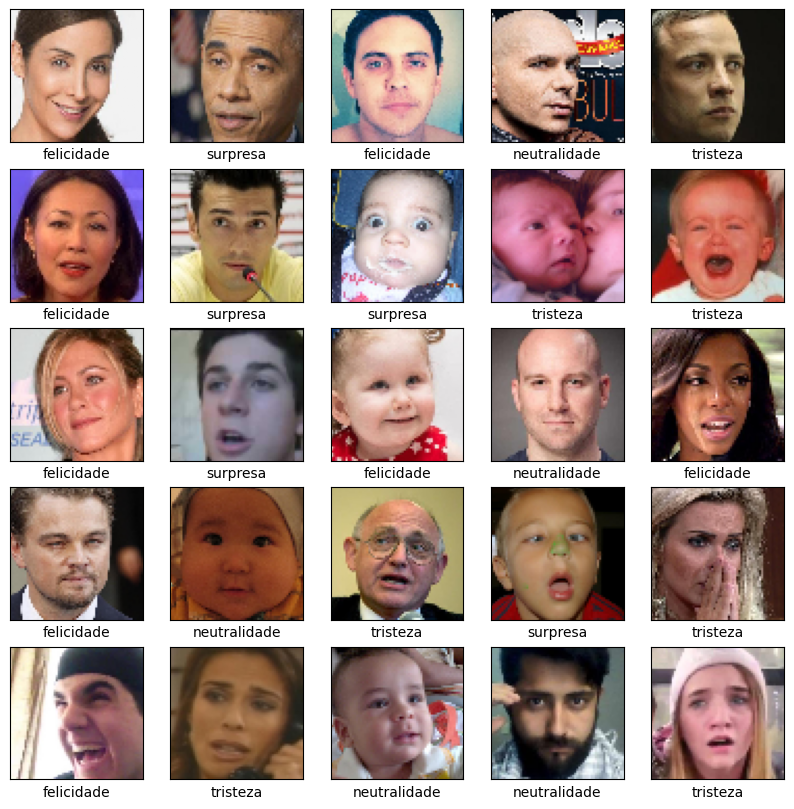

In [20]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    img_float32 = np.float32(train_images[i])
    plt.imshow(cv2.cvtColor(img_float32, cv2.COLOR_BGR2RGB) )
    # labels
    plt.xlabel( [k for k, v in label_dict.items() if v == train_l[i]][0] )
plt.show()

In [ ]:
data.shape

(20000, 64, 64, 3)

In [21]:
model = models.Sequential()
model.add(layers.Conv2D(50, kernel_size=(4, 4), activation='relu', input_shape=(64, 64, 3))) # 3 é sobre RGB
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(40, kernel_size=(4, 4), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(28, kernel_size=(4, 4), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(20, activation='relu')) # Dense: Núm. neurônios 1a cam
model.add(layers.Dense(10, activation='relu')) # Dense: Núm. neurônios 1a cam
model.add(layers.Dense(num_classes, activation="softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 61, 61, 50)        2450      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 30, 30, 50)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 40)        32040     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 13, 13, 40)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 28)        17948     
                                                                 
 flatten (Flatten)           (None, 2800)              0

In [22]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_images, train_l, epochs=2, batch_size=2,
                    validation_data=(test_images, test_l))

Epoch 1/5


c:\ProgramData\Anaconda3\lib\site-packages\keras\backend.py:5582: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


5000/5000 [==============================] - 49s 10ms/step - loss: 1.3948 - accuracy: 0.2470 - val_loss: 1.3868 - val_accuracy: 0.2466
Epoch 2/5
2474/5000 [=============>................] - ETA: 17s - loss: 1.3863 - accuracy: 0.2633

KeyboardInterrupt: 

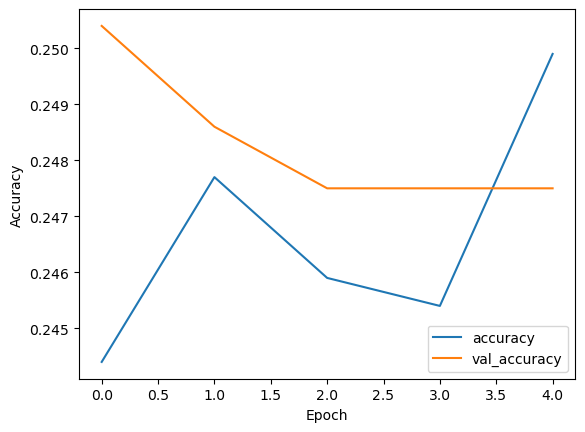

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='best')

In [ ]:
print("Generating test predictions...")
predict_x=model.predict(test_images)
print(np.around(predict_x, 2))

# make class predictions
predictions = (predict_x > 0.5).astype(int)

y_pred_class = np.argmax(predictions, axis=1)
y_test_class = np.argmax(test_labels, axis=1)

for i in range(len(test_labels)):
	if y_pred_class[i] == y_test_class[i]:
		print(f'\033[92m {y_pred_class[i]} (expected {y_test_class[i]})')
	else:
		print(f'\033[91m {y_pred_class[i]} (expected {y_test_class[i]})')

Generating test predictions...
313/313 [==============================] - 4s 13ms/step
[[0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 ...
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]]
 0 (expected 3)
 0 (expected 1)
 0 (expected 2)
 0 (expected 1)
 0 (expected 0)
 0 (expected 1)
 0 (expected 1)
 0 (expected 2)
 0 (expected 2)
 0 (expected 2)
 0 (expected 0)
 0 (expected 1)
 0 (expected 2)
 0 (expected 0)
 0 (expected 1)
 0 (expected 3)
 0 (expected 0)
 0 (expected 3)
 0 (expected 3)
 0 (expected 0)
 0 (expected 3)
 0 (expected 3)
 0 (expected 0)
 0 (expected 0)
 0 (expected 1)
 0 (expected 1)
 0 (expected 2)
 0 (expected 1)
 0 (expected 1)
 0 (expected 1)
 0 (expected 0)
 0 (expected 1)
 0 (expected 0)
 0 (expected 1)
 0 (expected 1)
 0 (expected 3)
 0 (expected 2)
 0 (expected 2)
 0 (expected 2)
 0 (expected 1)
 0 (expected 0)
 0 (expected 0)
 0 (expected 3)
 0 (expected 1)
 0 (expected 1)
 0 (expected 1)
 0 (expected 2)
 0 (expected 1)
 

In [ ]:
# Avaliando a acurácia com as imagens de Teste
l = len(y_test_class)
y_test2 = y_test_class
y_pred2 = y_pred_class
acc = sum([y_pred_class[i]==y_test_class[i] for i in range(l)])/l
print('Accuracy: %.2f %%' % (acc*100))

#f1score = 0
#f1score += f1_score(y_test2,y_pred2,average="weighted")
#print("Panicolada: ",round(100*f1score, 2),"%")
# Calcular com F_meansure


Accuracy: 25.32 %


array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

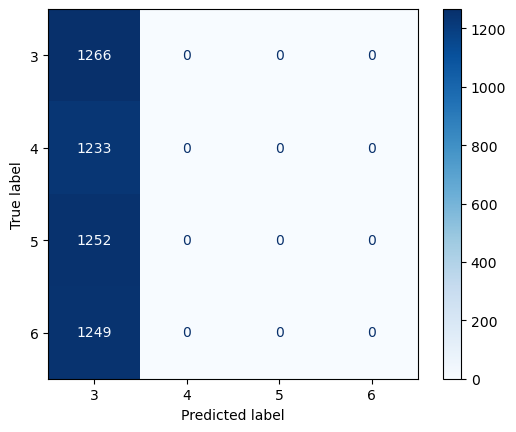

In [ ]:
import matplotlib.pyplot as plt
# voltando pro formato de classes
y_pred = np.argmax(predictions, axis=1)
y_test_c = np.argmax(test_labels, axis=1)


#Confusion Matrix
cm = confusion_matrix(y_test_c, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_dict)
disp.plot(cmap=plt.cm.Blues)

y_pred

In [ ]:
model.save(r'./newModel.hdf5')